In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.set_loglevel("info")

In [3]:
# Input files
df_file = "results/evaluation_all.tsv"
out_folder = "results"

# Set to None if you don't want to use it. Results will not be grouped/filtered by team
names_file = None

# Cumulate the last column of the cols variable, e.g. "pr" --> precision, so that the curves are monotonic as in CAFA
cumulate = True

# Add extreme points to the precision-recall curves (0, 1) and (1, 0)
add_extreme_points = True

# Methods with coverage below this threshold will not be plotted
coverage_threshold = 0.3

# Select a metric
#metric, cols = ('f', ['rc', 'pr'])
#metric, cols =  ('f_w', ['rc_w', 'pr_w'])
# metric, cols =  ('f_micro', ['rc_micro', 'pr_micro'])
# metric, cols =  ('f_micro_w', ['rc_micro_w', 'pr_micro_w'])
metric, cols = ('s', ['ru', 'mi'])

In [4]:
# Map column names to full names (for axis labels)
axis_title_dict = {'pr': 'Precision', 'rc': 'Recall', 'f': 'F-score', 'pr_w': 'Weighted Precision', 'rc_w': 'Weighted Recall', 'f_w': 'Weighted F-score', 'mi': 'Misinformation (Unweighted)', 'ru': 'Remaining Uncertainty (Unweighted)', 'mi_w': 'Misinformation', 'ru_w': 'Remaining Uncertainty', 's': 'S-score', 'pr_micro': 'Precision (Micro)', 'rc_micro': 'Recall (Micro)', 'f_micro': 'F-score (Micro)', 'pr_micro_w': 'Weighted Precision (Micro)', 'rc_micro_w': 'Weighted Recall (Micro)', 'f_micro_w': 'Weighted F-score (Micro)'}

# Map ontology namespaces to full names (for plot titles)
ontology_dict = {'biological_process': 'BPO', 'molecular_function': 'MFO', 'cellular_component': 'CCO'}

In [5]:
df = pd.read_csv(df_file, sep="\t")
df["filename"] = df["filename"].replace({
    "deep_ec_results.tsv": "DeepEC CNN3",
    "dspace_results.tsv": "D-SPACE EC",
    "esm1b_results.tsv": "DNN ESM1b",
    "esm2_3B_results.tsv": "DNN ESM2 3B",
    "prot_bert_results.tsv": "DNN ProtBERT"
})

df

,filename,ns,tau,n,tp,fp,fn,pr,rc,cov,mi,ru,f,s,pr_micro,rc_micro,f_micro
0,DeepEC CNN3,ec_numbers,0.01,75565.0,3.569,4.470,0.355,0.612,0.910,1.000,4.470,0.355,0.732,4.485,0.444,0.909,0.597
1,DeepEC CNN3,ec_numbers,0.02,75565.0,3.569,4.470,0.355,0.612,0.910,1.000,4.470,0.355,0.732,4.485,0.444,0.909,0.597
2,DeepEC CNN3,ec_numbers,0.03,75563.0,3.538,3.672,0.386,0.641,0.902,1.000,3.672,0.386,0.750,3.693,0.491,0.902,0.635
3,DeepEC CNN3,ec_numbers,0.04,75560.0,3.512,3.183,0.412,0.662,0.896,1.000,3.183,0.412,0.761,3.210,0.525,0.895,0.661
4,DeepEC CNN3,ec_numbers,0.05,75557.0,3.492,2.839,0.432,0.677,0.890,1.000,2.839,0.432,0.769,2.872,0.552,0.890,0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,DNN ProtBERT,ec_numbers,0.95,72169.0,3.483,0.056,0.441,0.981,0.886,0.955,0.056,0.441,0.931,0.445,0.984,0.888,0.933
491,DNN ProtBERT,ec_numbers,0.96,71854.0,3.463,0.052,0.461,0.982,0.881,0.951,0.052,0.461,0.929,0.464,0.985,0.882,0.931
492,DNN ProtBERT,ec_numbers,0.97,71450.0,3.436,0.046,0.488,0.984,0.874,0.946,0.046,0.488,0.926,0.490,0.987,0.876,0.928
493,DNN ProtBERT,ec_numbers,0.98,70882.0,3.394,0.040,0.530,0.986,0.863,0.938,0.040,0.530,0.920,0.531,0.988,0.865,0.923


In [6]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'D-SPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

df["colors"] = df["filename"].apply(lambda x: color_map[x])

In [7]:
# Set method information (optional)
if names_file is None:
    df['group'] = df['filename']
    df['label'] = df['filename']
    df['is_baseline'] = False
else:
    methods = pd.read_csv(names_file, delim_whitespace=True, header=0)
    df = pd.merge(df, methods, on='filename', how='left')
    df['group'].fillna(df['filename'], inplace=True)
    df['label'].fillna(df['filename'], inplace=True)
    if 'is_baseline' not in df:
        df['is_baseline'] = False
    else:
        df['is_baseline'].fillna(False, inplace=True)
    # print(methods)
df = df.drop(columns='filename').set_index(['group', 'label', 'ns', 'tau'])
df

n     tp     fp     fn  \
group        label        ns         tau                                  
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  75565.0  3.569  4.470  0.355   
                                     0.02  75565.0  3.569  4.470  0.355   
                                     0.03  75563.0  3.538  3.672  0.386   
                                     0.04  75560.0  3.512  3.183  0.412   
                                     0.05  75557.0  3.492  2.839  0.432   
...                                            ...    ...    ...    ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  72169.0  3.483  0.056  0.441   
                                     0.96  71854.0  3.463  0.052  0.461   
                                     0.97  71450.0  3.436  0.046  0.488   
                                     0.98  70882.0  3.394  0.040  0.530   
                                     0.99  69737.0  3.315  0.030  0.609   

                                              pr     rc    cov     mi     ru  \
group        label        ns         tau                                       
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  0.612  0.910  1.000  4.470  0.355   
                                     0.02  0.612  0.910  1.000  4.470  0.355   
                                     0.03  0.641  0.902  1.000  3.672  0.386   
                                     0.04  0.662  0.896  1.000  3.183  0.412   
                                     0.05  0.677  0.890  1.000  2.839  0.432   
...                                          ...    ...    ...    ...    ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  0.981  0.886  0.955  0.056  0.441   
                                     0.96  0.982  0.881  0.951  0.052  0.461   
                                     0.97  0.984  0.874  0.946  0.046  0.488   
                                     0.98  0.986  0.863  0.938  0.040  0.530   
                                     0.99  0.989  0.842  0.923  0.030  0.609   

                                               f      s  pr_micro  rc_micro  \
group        label        ns         tau                                      
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  0.732  4.485     0.444     0.909   
                                     0.02  0.732  4.485     0.444     0.909   
                                     0.03  0.750  3.693     0.491     0.902   
                                     0.04  0.761  3.210     0.525     0.895   
                                     0.05  0.769  2.872     0.552     0.890   
...                                          ...    ...       ...       ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  0.931  0.445     0.984     0.888   
                                     0.96  0.929  0.464     0.985     0.882   
                                     0.97  0.926  0.490     0.987     0.876   
                                     0.98  0.920  0.531     0.988     0.865   
                                     0.99  0.910  0.609     0.991     0.845   

                                           f_micro  \
group        label        ns         tau             
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01    0.597   
                                     0.02    0.597   
                                     0.03    0.635   
                                     0.04    0.661   
                                     0.05    0.681   
...                                            ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95    0.933   
                                     0.96    0.931   
                                     0.97    0.928   
                                     0.98    0.923   
                                     0.99    0.912   

                                                                                      colors  \
group        label        ns         tau                                                       
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  (0.5803921568627451, 0.5803921568627451, 0.580...   
             

In [8]:
# Filter by coverage
df = df[df['cov'] >= coverage_threshold]
df

n     tp     fp     fn  \
group        label        ns         tau                                  
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  75565.0  3.569  4.470  0.355   
                                     0.02  75565.0  3.569  4.470  0.355   
                                     0.03  75563.0  3.538  3.672  0.386   
                                     0.04  75560.0  3.512  3.183  0.412   
                                     0.05  75557.0  3.492  2.839  0.432   
...                                            ...    ...    ...    ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  72169.0  3.483  0.056  0.441   
                                     0.96  71854.0  3.463  0.052  0.461   
                                     0.97  71450.0  3.436  0.046  0.488   
                                     0.98  70882.0  3.394  0.040  0.530   
                                     0.99  69737.0  3.315  0.030  0.609   

                                              pr     rc    cov     mi     ru  \
group        label        ns         tau                                       
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  0.612  0.910  1.000  4.470  0.355   
                                     0.02  0.612  0.910  1.000  4.470  0.355   
                                     0.03  0.641  0.902  1.000  3.672  0.386   
                                     0.04  0.662  0.896  1.000  3.183  0.412   
                                     0.05  0.677  0.890  1.000  2.839  0.432   
...                                          ...    ...    ...    ...    ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  0.981  0.886  0.955  0.056  0.441   
                                     0.96  0.982  0.881  0.951  0.052  0.461   
                                     0.97  0.984  0.874  0.946  0.046  0.488   
                                     0.98  0.986  0.863  0.938  0.040  0.530   
                                     0.99  0.989  0.842  0.923  0.030  0.609   

                                               f      s  pr_micro  rc_micro  \
group        label        ns         tau                                      
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  0.732  4.485     0.444     0.909   
                                     0.02  0.732  4.485     0.444     0.909   
                                     0.03  0.750  3.693     0.491     0.902   
                                     0.04  0.761  3.210     0.525     0.895   
                                     0.05  0.769  2.872     0.552     0.890   
...                                          ...    ...       ...       ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95  0.931  0.445     0.984     0.888   
                                     0.96  0.929  0.464     0.985     0.882   
                                     0.97  0.926  0.490     0.987     0.876   
                                     0.98  0.920  0.531     0.988     0.865   
                                     0.99  0.910  0.609     0.991     0.845   

                                           f_micro  \
group        label        ns         tau             
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01    0.597   
                                     0.02    0.597   
                                     0.03    0.635   
                                     0.04    0.661   
                                     0.05    0.681   
...                                            ...   
DNN ProtBERT DNN ProtBERT ec_numbers 0.95    0.933   
                                     0.96    0.931   
                                     0.97    0.928   
                                     0.98    0.923   
                                     0.99    0.912   

                                                                                      colors  \
group        label        ns         tau                                                       
DeepEC CNN3  DeepEC CNN3  ec_numbers 0.01  (0.5803921568627451, 0.5803921568627451, 0.580...   
             

In [9]:
# Identify the best methods and thresholds
index_best = df.groupby(level=['group', 'ns'])[metric].idxmax() if metric in ['f', 'f_w', 'f_micro', 'f_micro_w'] else df.groupby(['group', 'ns'])[metric].idxmin()
index_best

group         ns        
D-SPACE EC    ec_numbers        (D-SPACE EC, D-SPACE EC, ec_numbers, 0.5)
DNN ESM1b     ec_numbers         (DNN ESM1b, DNN ESM1b, ec_numbers, 0.42)
DNN ESM2 3B   ec_numbers     (DNN ESM2 3B, DNN ESM2 3B, ec_numbers, 0.46)
DNN ProtBERT  ec_numbers    (DNN ProtBERT, DNN ProtBERT, ec_numbers, 0.5)
DeepEC CNN3   ec_numbers     (DeepEC CNN3, DeepEC CNN3, ec_numbers, 0.63)
Name: s, dtype: object

In [10]:
# Filter the dataframe for the best methods
df_methods = df.reset_index('tau').loc[[ele[:-1] for ele in index_best], ['tau', 'cov', 'colors'] + cols + [metric]].sort_index()

# Makes the curves monotonic. Cumulative max on the last column of the cols variable, e.g. "pr" --> precision
if cumulate:
    if metric in ['f', 'f_w', 'f_micro', 'f_micro_w']:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummax()
    else:
        df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummin()


# Save to file
df_methods.drop(columns=['colors']).to_csv('{}/fig_{}.tsv'.format(out_folder, metric), float_format="%.3f", sep="\t")
df_methods

tau    cov  \
group       label       ns                        
D-SPACE EC  D-SPACE EC  ec_numbers  0.01  1.000   
                        ec_numbers  0.02  1.000   
                        ec_numbers  0.03  1.000   
                        ec_numbers  0.04  1.000   
                        ec_numbers  0.05  1.000   
...                                  ...    ...   
DeepEC CNN3 DeepEC CNN3 ec_numbers  0.95  0.840   
                        ec_numbers  0.96  0.829   
                        ec_numbers  0.97  0.816   
                        ec_numbers  0.98  0.796   
                        ec_numbers  0.99  0.765   

                                                                               colors  \
group       label       ns                                                              
D-SPACE EC  D-SPACE EC  ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
...                                                                               ...   
DeepEC CNN3 DeepEC CNN3 ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   

                                       ru     mi      s  
group       label       ns                               
D-SPACE EC  D-SPACE EC  ec_numbers  0.516  1.519  1.604  
                        ec_numbers  0.516  1.519  1.604  
                        ec_numbers  0.537  1.320  1.425  
                        ec_numbers  0.552  1.192  1.314  
                        ec_numbers  0.565  1.100  1.237  
...                                   ...    ...    ...  
DeepEC CNN3 DeepEC CNN3 ec_numbers  1.138  0.138  1.146  
                        ec_numbers  1.172  0.123  1.179  
                        ec_numbers  1.217  0.107  1.222  
                        ec_numbers  1.279  0.087  1.282  
                        ec_numbers  1.385  0.065  1.386  

[495 rows x 6 columns]

In [11]:
# Add first last points to precision and recall curves to improve APS calculation
def add_points(df_):
    df_ = pd.concat([df_.iloc[0:1], df_])
    df_.iloc[0, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [0, 1, 0]  # tau, rc, pr
    df_ = pd.concat([df_, df_.iloc[-1:]])
    df_.iloc[-1, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [1.1, 0, 1]
    return df_

if metric.startswith('f') and add_extreme_points:
    df_methods = df_methods.reset_index().groupby(['group', 'label', 'ns'], as_index=False).apply(add_points).set_index(['group', 'label', 'ns'])
df_methods

tau    cov  \
group       label       ns                        
D-SPACE EC  D-SPACE EC  ec_numbers  0.01  1.000   
                        ec_numbers  0.02  1.000   
                        ec_numbers  0.03  1.000   
                        ec_numbers  0.04  1.000   
                        ec_numbers  0.05  1.000   
...                                  ...    ...   
DeepEC CNN3 DeepEC CNN3 ec_numbers  0.95  0.840   
                        ec_numbers  0.96  0.829   
                        ec_numbers  0.97  0.816   
                        ec_numbers  0.98  0.796   
                        ec_numbers  0.99  0.765   

                                                                               colors  \
group       label       ns                                                              
D-SPACE EC  D-SPACE EC  ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
                        ec_numbers      (0.9254901960784314, 0.8823529411764706, 0.2)   
...                                                                               ...   
DeepEC CNN3 DeepEC CNN3 ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   
                        ec_numbers  (0.5803921568627451, 0.5803921568627451, 0.580...   

                                       ru     mi      s  
group       label       ns                               
D-SPACE EC  D-SPACE EC  ec_numbers  0.516  1.519  1.604  
                        ec_numbers  0.516  1.519  1.604  
                        ec_numbers  0.537  1.320  1.425  
                        ec_numbers  0.552  1.192  1.314  
                        ec_numbers  0.565  1.100  1.237  
...                                   ...    ...    ...  
DeepEC CNN3 DeepEC CNN3 ec_numbers  1.138  0.138  1.146  
                        ec_numbers  1.172  0.123  1.179  
                        ec_numbers  1.217  0.107  1.222  
                        ec_numbers  1.279  0.087  1.282  
                        ec_numbers  1.385  0.065  1.386  

[495 rows x 6 columns]

In [12]:
# Filter the dataframe for the best method and threshold
df_best = df.loc[index_best, ['cov', 'colors'] + cols + [metric]]
df_best

,,,,cov,colors,ru,mi,s
group,label,ns,tau,,,,,
D-SPACE EC,D-SPACE EC,ec_numbers,0.50,0.984,"(0.9254901960784314, 0.8823529411764706, 0.2)",0.738,0.414,0.846
DNN ESM1b,DNN ESM1b,ec_numbers,0.42,0.995,"(0.984313725490196, 0.6862745098039216, 0.8941...",0.202,0.159,0.257
DNN ESM2 3B,DNN ESM2 3B,ec_numbers,0.46,0.996,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.190,0.147,0.240
DNN ProtBERT,DNN ProtBERT,ec_numbers,0.50,0.991,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.249,0.174,0.303
DeepEC CNN3,DeepEC CNN3,ec_numbers,0.63,0.956,"(0.5803921568627451, 0.5803921568627451, 0.580...",0.807,0.467,0.932


In [13]:
# Calculate average precision score 
if metric.startswith('f'):
    df_best['aps'] = df_methods.groupby(level=['group', 'label', 'ns'])[[cols[0], cols[1]]].apply(lambda x: (x[cols[0]].diff(-1).shift(1) * x[cols[1]]).sum())
df_best

,,,,cov,colors,ru,mi,s
group,label,ns,tau,,,,,
D-SPACE EC,D-SPACE EC,ec_numbers,0.50,0.984,"(0.9254901960784314, 0.8823529411764706, 0.2)",0.738,0.414,0.846
DNN ESM1b,DNN ESM1b,ec_numbers,0.42,0.995,"(0.984313725490196, 0.6862745098039216, 0.8941...",0.202,0.159,0.257
DNN ESM2 3B,DNN ESM2 3B,ec_numbers,0.46,0.996,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.190,0.147,0.240
DNN ProtBERT,DNN ProtBERT,ec_numbers,0.50,0.991,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.249,0.174,0.303
DeepEC CNN3,DeepEC CNN3,ec_numbers,0.63,0.956,"(0.5803921568627451, 0.5803921568627451, 0.580...",0.807,0.467,0.932


In [14]:
# Calculate the max coverage across all thresholds
df_best['max_cov'] = df_methods.groupby(level=['group', 'label', 'ns'])['cov'].max()
df_best

,,,,cov,colors,ru,mi,s,max_cov
group,label,ns,tau,,,,,,
D-SPACE EC,D-SPACE EC,ec_numbers,0.50,0.984,"(0.9254901960784314, 0.8823529411764706, 0.2)",0.738,0.414,0.846,1.0
DNN ESM1b,DNN ESM1b,ec_numbers,0.42,0.995,"(0.984313725490196, 0.6862745098039216, 0.8941...",0.202,0.159,0.257,1.0
DNN ESM2 3B,DNN ESM2 3B,ec_numbers,0.46,0.996,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.190,0.147,0.240,1.0
DNN ProtBERT,DNN ProtBERT,ec_numbers,0.50,0.991,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.249,0.174,0.303,1.0
DeepEC CNN3,DeepEC CNN3,ec_numbers,0.63,0.956,"(0.5803921568627451, 0.5803921568627451, 0.580...",0.807,0.467,0.932,1.0


In [15]:
# Set a label column for the plot legend
df_best['label'] = df_best.index.get_level_values('label')
if 'aps' not in df_best.columns:
    df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}-min={x[metric]:.3f})", axis=1)
else:
    df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} APS={x['aps']:.3f} C={x['max_cov']:.3f})", axis=1)
df_best

,,,,cov,colors,ru,mi,s,max_cov,label
group,label,ns,tau,,,,,,,
D-SPACE EC,D-SPACE EC,ec_numbers,0.50,0.984,"(0.9254901960784314, 0.8823529411764706, 0.2)",0.738,0.414,0.846,1.0,D-SPACE EC (S-min=0.846)
DNN ESM1b,DNN ESM1b,ec_numbers,0.42,0.995,"(0.984313725490196, 0.6862745098039216, 0.8941...",0.202,0.159,0.257,1.0,DNN ESM1b (S-min=0.257)
DNN ESM2 3B,DNN ESM2 3B,ec_numbers,0.46,0.996,"(0.8, 0.47058823529411764, 0.7372549019607844)",0.190,0.147,0.240,1.0,DNN ESM2 3B (S-min=0.240)
DNN ProtBERT,DNN ProtBERT,ec_numbers,0.50,0.991,"(0.8352941176470589, 0.3686274509803922, 0.0)",0.249,0.174,0.303,1.0,DNN ProtBERT (S-min=0.303)
DeepEC CNN3,DeepEC CNN3,ec_numbers,0.63,0.956,"(0.5803921568627451, 0.5803921568627451, 0.580...",0.807,0.467,0.932,1.0,DeepEC CNN3 (S-min=0.932)


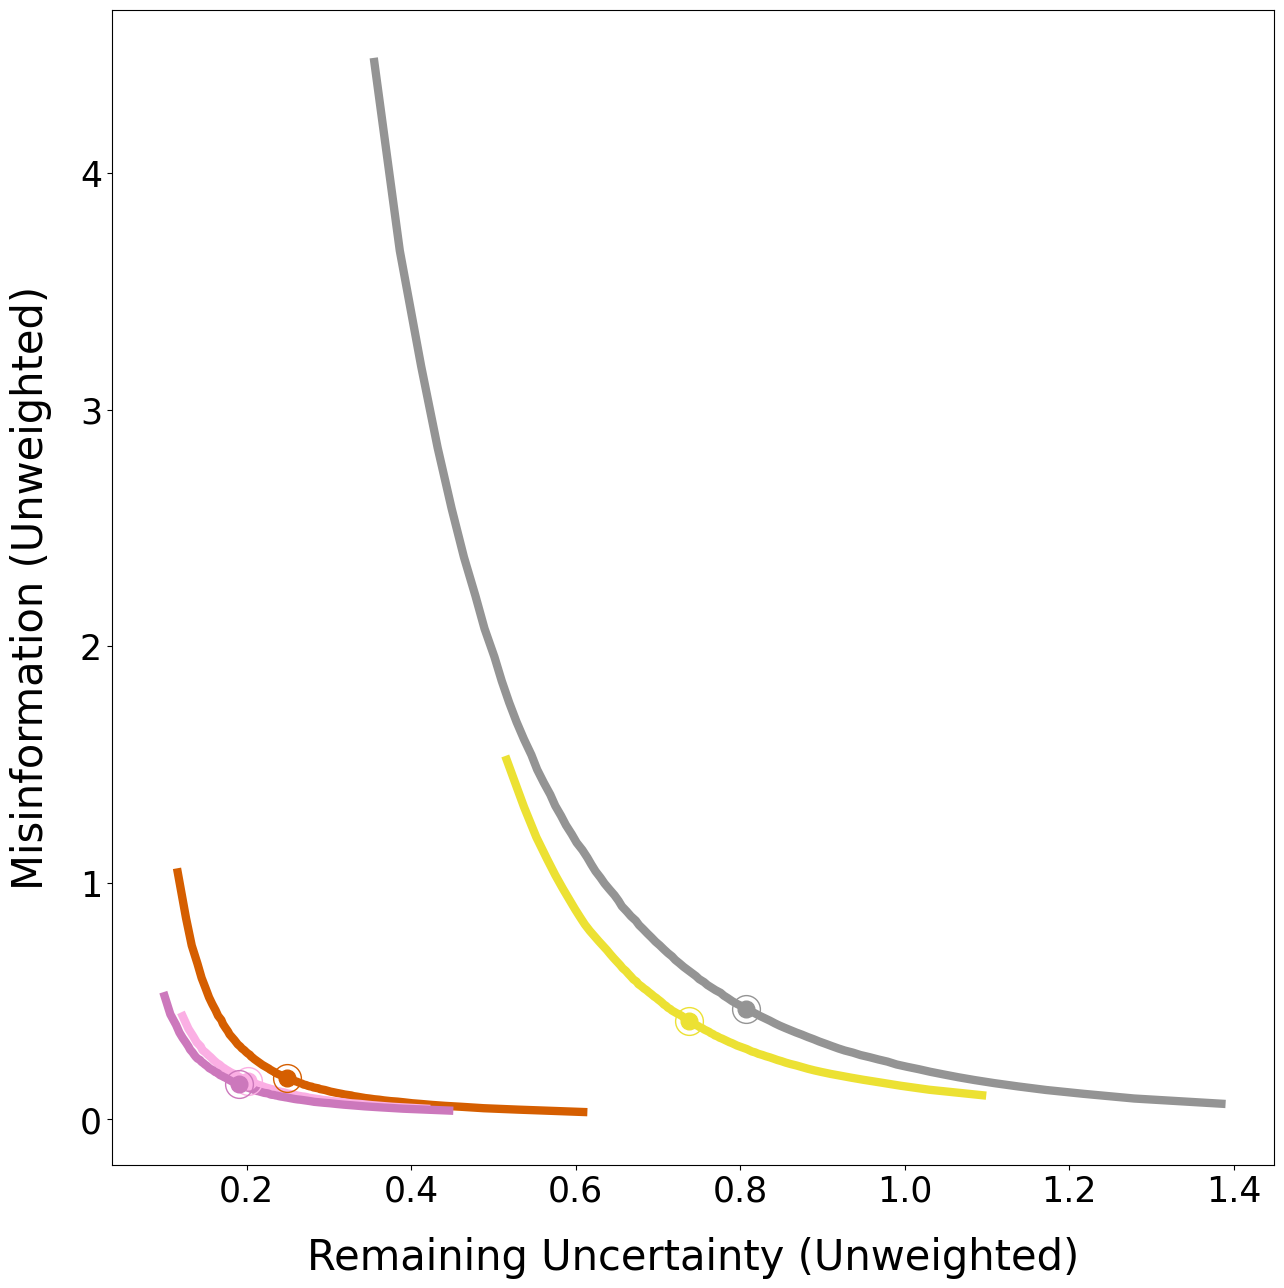

In [16]:
# Generate the figures
plt.rcParams.update({'font.size': 25, 'legend.fontsize': 25})

# F-score contour lines
x = np.arange(0.01, 1, 0.01)
y = np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x, y)
Z = 2 * X * Y / (X + Y)

for ns, df_g in df_best.groupby(level='ns'):
    fig, ax = plt.subplots(figsize=(15, 15))

     # Contour lines. At the moment they are provided only for the F-score
    if metric.startswith('f'):
        CS = ax.contour(X, Y, Z, np.arange(0.1, 1.0, 0.1), colors='gray')
        ax.clabel(CS, inline=True) #, fontsize=10)

    # Iterate methods
    for i, (index, row) in enumerate(df_g.sort_values(by=[metric, 'max_cov'], ascending=[False if metric.startswith('f') else True, False]).iterrows()):
        data = df_methods.loc[index[:-1]]
        
        # Precision-recall or mi-ru curves
        ax.plot(data[cols[0]], data[cols[1]], color=row['colors'], label=row['label'], lw=6, zorder=500-i)
        
        # F-max or S-min dots
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=20, mfc='none', zorder=1000-i)
        ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=12, zorder=1000-i)

    # Set axes limit
    if metric.startswith('f'):
        plt.xlim(0, 1)
        plt.ylim(0, 1)
   
    # plt.xlim(0, max(1, df_best.loc[:,:,ns,:][cols[0]].max()))
    # plt.ylim(0, max(1, df_best.loc[:,:,ns,:][cols[1]].max()))

    # Set titles
    # ax.set_title(, pad=20)
    ax.set_xlabel(axis_title_dict[cols[0]], labelpad=20, size=30)
    ax.set_ylabel(axis_title_dict[cols[1]], labelpad=20, size=30)

    
    # Legend
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # leg = ax.legend(markerscale=6)
    for legobj in legend.get_lines():
        legobj.set_linewidth(10.0)

    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("legend.png", dpi="figure", bbox_inches=bbox)
    legend.remove()

    # plt.xticks(size=22)
    # plt.yticks(size=22)
    # Save figure on disk
    plt.savefig("{}/fig_{}_{}.png".format(out_folder, metric, ns), bbox_inches='tight', dpi=300, transparent=True)
    # plt.clf()